<div style="text-align: center;">

#  Steam Game Popularity Analysis & Prediction


##  Allen Arriaga

###  11/13/2025
  

</div>


Video game popularity and player engagement are critical factors for success in the gaming industry. On platforms like Steam, pricing strategies such as discounts can significantly influence player activity and overall game sales. Understanding the factors that drive game popularity helps developers and publishers make more informed marketing and pricing decisions. This analysis explores how discounts, developer presence, and player behavior interact to shape a game's overall visibility and performance on the platform.

In this analysis, I used data analysis and machine learning techniques to examine how discounts, pricing, and player activity relate to a game’s popularity and engagement levels on Steam. By applying Random Forest regression modeling, I investigated which features—such as discount percentage, concurrent users, and reviews—most strongly predict game ownership and positive player feedback.


The main question of this investigation is: “How do discounts and player activity affect game popularity on Steam?”

#1. Data Description and Processing

The dataset used in this analysis was collected from the Steam gaming platform and includes a variety of game-specific, developer, and player engagement characteristics. Each observation represents data from an individual game available on Steam during the study period.

This dataset contains several types of variables related to game pricing, player activity, and popularity metrics. Key features include game price, discount rate, number of owners, concurrent users, developer, and counts of positive and negative reviews. These variables provide insight into how economic and engagement factors interact to influence overall game success.

#### Variable Descriptions
appid: The unique Steam Application ID for the game.  
name: The name of the game.  
developer: A comma-separated list of the game's developers.  
publisher: A comma-separated list of the game's publishers.  
owners: The estimated number of owners of this application on Steam.  
average_forever: The average total playtime since March 2009 (minutes).  
median_forever: The median total playtime since March 2009 (minutes).  
average_2weeks: The average playtime in the last two weeks (minutes).  
median_2weeks: The median playtime in the last two weeks (minutes).  
ccu: The peak Concurrent Users (CCU) for the game yesterday.  
price: The current US price of the game.  
initialprice: The original US price of the game.  
discount: The current discount on the game (percent).  


The dataset was preprocessed in MySQL before being imported into Python for analysis. Initially, the dataset contained 347 records. After preprocessing, the cleaned dataset contained 339 complete observations. Additional outlier filtering was then performed in Python using the interquartile range (IQR) method, resulting in a final dataset of 270 games used for modeling and visualization.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
conn = mysql.connector.connect(
    host='localhost',       
    user='root',            
    password='Allenis#1',
    database='steam_project'
)

In [4]:
df = pd.read_sql("SELECT * FROM steam_data_fixed;", conn)

In [5]:
##removing outliers from 'ccu' and 'owners' using IQR

In [6]:
Q1_ccu = df['ccu'].quantile(0.25)
Q3_ccu = df['ccu'].quantile(0.75)
IQR_ccu = Q3_ccu - Q1_ccu

In [7]:
lower_bound_ccu = Q1_ccu - 1.5 * IQR_ccu
upper_bound_ccu = Q3_ccu + 1.5 * IQR_ccu

In [8]:
Q1_owners = df['owners'].quantile(0.25)
Q3_owners = df['owners'].quantile(0.75)
IQR_owners = Q3_owners - Q1_owners

In [9]:
lower_bound_owners = Q1_owners - 1.5 * IQR_owners
upper_bound_owners = Q3_owners + 1.5 * IQR_owners

In [10]:
df_filtered = df[
    (df['owners'] >= lower_bound_owners) & (df['owners'] <= upper_bound_owners) &
    (df['ccu'] >= lower_bound_ccu) & (df['ccu'] <= upper_bound_ccu)
]

#  2. Steam Game Trends and Insights

###  Do higher discounts bring in more players?

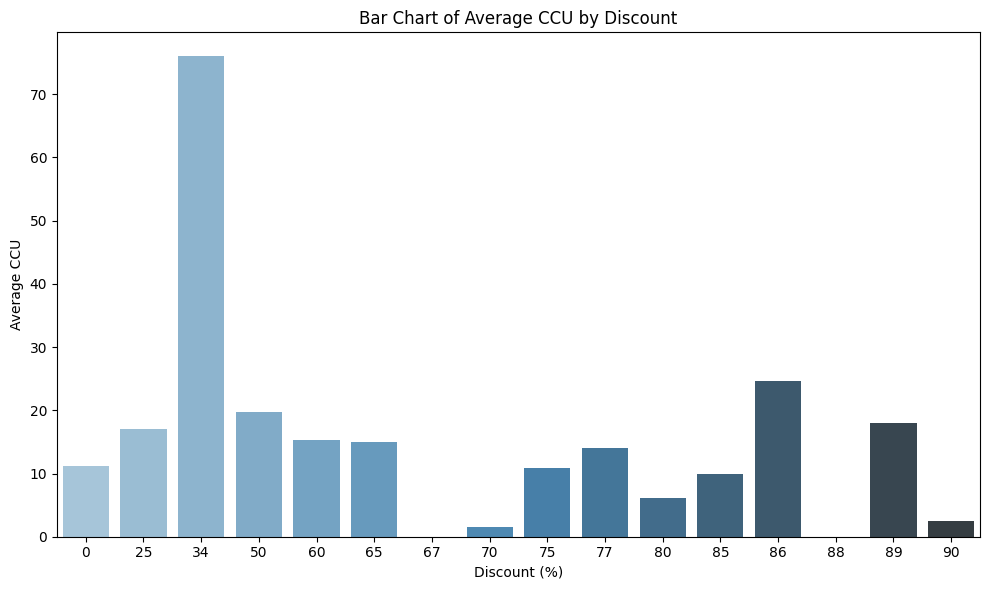

In [11]:
avg_df = df_filtered.groupby("discount")["ccu"].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=avg_df, x="discount", y="ccu", palette="Blues_d")

plt.title("Bar Chart of Average CCU by Discount")
plt.xlabel("Discount (%)")
plt.ylabel("Average CCU")
plt.tight_layout()
plt.show()


Moderate discounts seem to draw the most active players, but extreme discounts don’t necessarily lead to higher player activity — suggesting that game popularity matters more than price cuts alone.

###What developers make popular games (based on the number of owners)?                                                                                                    

In [12]:
# Total owners by developer (top 10)
top_developers = (
    df_filtered.groupby("developer")["owners"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)

In [13]:
# Format numbers with commas
top_developers["owners"] = top_developers["owners"].apply(lambda x: f"{x:,}")

# Rename columns 
top_developers.columns = ["Developer", "Total Owners"]

print(top_developers.to_string(index=False))

                                   Developer Total Owners
                                 id software    5,700,000
                                   ion storm    3,750,000
                         relic entertainment    3,750,000
                                     egosoft    3,100,000
                    microprose software, inc    3,100,000
id software, nightdive studios, machinegames    3,000,000
                                   rebellion    2,825,000
                          popcap games, inc.    2,600,000
                        reality pump studios    2,600,000
                                pyro studios    2,600,000


###number of times a specific developer shows up in the dataset

In [14]:
#number of times these developers show up in the dataset
df_filtered["developer_clean"] = df_filtered["developer"].str.strip().str.lower()

top_devs_clean = [
    'id software',
    'ion storm',
    'relic entertainment',
    'egosoft',
    'microprose software, inc',
    'id software, nightdive studios, machinegames',
    'rebellion',
    'popcap games, inc.',
    'reality pump studios',
    'pyro studios'
]
top_devs_clean = [d.strip().lower() for d in top_devs_clean]

# Filter and count
top_dev_counts = (
    df_filtered[df_filtered["developer_clean"].isin(top_devs_clean)]["developer_clean"]
      .value_counts()
      .reset_index()
)

In [15]:
# Rename columns
top_dev_counts.columns = ["Developer", "Game Count"]

print(top_dev_counts.to_string(index=False))

                                   Developer  Game Count
                          popcap games, inc.          18
                                 id software           9
                                     egosoft           6
                                   rebellion           5
                    microprose software, inc           5
                                pyro studios           4
                        reality pump studios           3
                         relic entertainment           3
                                   ion storm           3
id software, nightdive studios, machinegames           2


In [16]:
data = {
    "developer": [
        "id software", "ion storm", "relic entertainment",
        "egosoft", "microprose software, inc",
        "id software, nightdive studios, machinegames",
        "rebellion", "popcap games, inc.",
        "reality pump studios", "pyro studios"
    ],
    "owners": [
        5700000, 3750000, 3750000, 3100000, 3100000,
        3000000, 2825000, 2600000, 2600000, 2600000
    ]
}

In [17]:
top_devs = pd.DataFrame(data)

# Sort developers by owners descending 
top_devs = top_devs.sort_values("owners", ascending=False)

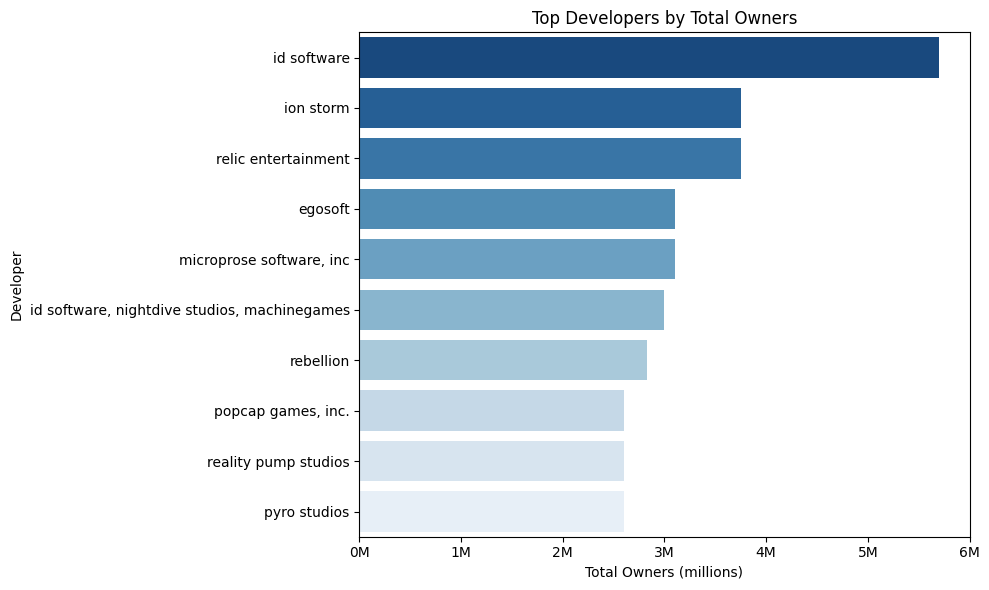

In [18]:

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_devs, x="owners", y="developer", palette="Blues_r")

plt.title("Top Developers by Total Owners")
plt.xlabel("Total Owners (millions)")
plt.ylabel("Developer")

# Format x-axis tick labels as millions
x_ticks = plt.xticks()[0]
plt.xticks(x_ticks, [f"{int(x/1e6)}M" for x in x_ticks])

plt.tight_layout()
plt.show()

#3. Predictive Modeling for Game Success

###how many good reviews will a new game have?

To answer this question, I trained a Random Forest model using features like price, discount, positive and negative reviews, playtime, and concurrent users to predict the number of owners. The model learns patterns from historical game data and evaluates its accuracy using the R² score. Random Forest model was best for this analysis due to its ability to capture the complex relationships between game features—like price, reviews, and player activity—and the number of owners, giving accurate and reliable predictions.

In [19]:

features = ["price", "discount", "positive", "negative", "average_forever", "ccu"]
X = df_filtered[features]
y = df_filtered["owners"]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("R² score:", r2_score(y_test, preds))

feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feat_importance)

R² score: 0.5483477182099525
positive           0.689091
negative           0.162119
ccu                0.058126
average_forever    0.047186
price              0.027191
discount           0.016287
dtype: float64


In [20]:
# Feature importance data 
feat_importance = pd.Series({
    "ccu": 0.058126,
    "positive": 0.689091,
    "negative": 0.162119,
    "average_forever": 0.047186,
    "price": 0.027191,
    "discount": 0.016287
})

# Sort values 
feat_importance = feat_importance.sort_values(ascending=True)

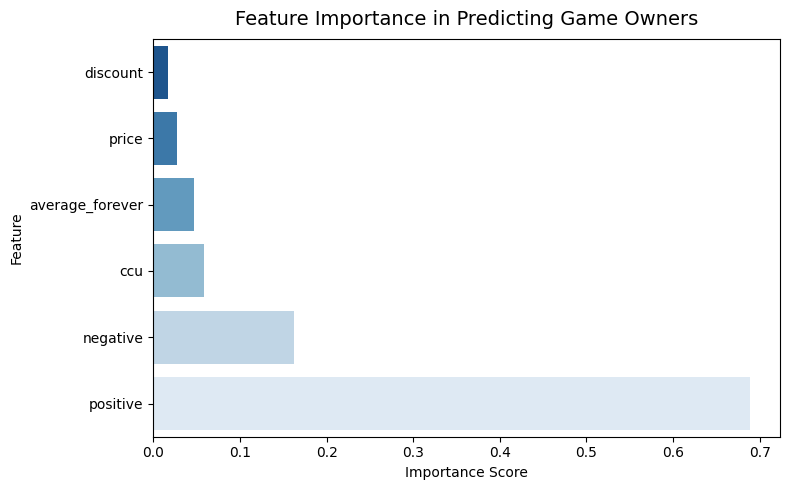

In [21]:
# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=feat_importance, y=feat_importance.index, palette="Blues_r")

plt.title("Feature Importance in Predicting Game Owners", fontsize=14, pad=10)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The feature importance results indicate that positive reviews(positive), negative reviews, and ccu are the strongest predictors of game ownership. In contrast, price and discount rate have minimal influence. This suggests that player engagement and community feedback are far more indicative of a game’s success than short-term pricing factors.

###Predicting how many owners a new game would get given hypothetical inputs

In [22]:
new_game = pd.DataFrame({
    "price": [9.99],
    "discount": [30],
    "positive": [12000],
    "negative": [800],
    "average_forever": [2000],
    "ccu": [1500]
})

# Predict number of owners
predicted_owners = model.predict(new_game)
print("Predicted number of owners:", int(predicted_owners[0]))


Predicted number of owners: 1275000


In [23]:
#predicting positive reviews
# Select features and target
features2 = ["price", "discount", "owners", "negative", "average_forever", "ccu"]
X2 = df_filtered[features2].copy()  # use .copy() to avoid any reference issues
y2 = df_filtered["positive"].copy()

# Split dataset into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

# Train Random Forest model
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(X_train2, y_train2)

# Make predictions
preds2 = model2.predict(X_test2)

# Evaluate model
print("R² score:", r2_score(y_test2, preds2))

# Feature importance
feat_importance2 = pd.Series(
    model2.feature_importances_, index=X2.columns
).sort_values(ascending=False)
print(feat_importance2)

R² score: 0.8614432198138235
ccu                0.318455
owners             0.316578
negative           0.259790
average_forever    0.050455
price              0.044653
discount           0.010069
dtype: float64


In [24]:
new_game2 = pd.DataFrame({
    "price": [9.99],
    "discount": [30],
    "owners": [1200000],
    "negative": [800],
    "average_forever": [2000],
    "ccu": [1500]
})

In [25]:
new_game2 = new_game2[features2].copy()

# Predict number of positive reviews
predicted_positive_reviews2 = model2.predict(new_game2)
print("Predicted number of positive reviews:", int(predicted_positive_reviews2[0]))

Predicted number of positive reviews: 14251


This Random Forest model is a good fit(R² = 0.86), effectively capturing the relationship between gameplay and popularity factors. Positive review counts are primarily driven by engagement (CCU) and player reach (owners), suggesting that active communities and game visibility are far more important predictors of positive reception than pricing or discounts.

###how does predicted ownership change as discount increases?

In [26]:

features_owners = ["price", "discount", "positive", "negative", "average_forever", "ccu"]

#range of discounts to test
discount_range = [10, 20, 30, 40, 50]

In [27]:
scenario_df = pd.DataFrame({
    "price": [9.99]*5,
    "discount": [10, 20, 30, 40, 50],
    "positive": [500]*5,        
    "negative": [800]*5,
    "average_forever": [2000]*5,
    "ccu": [1500]*5
})

In [28]:
# Predict ownership for each discount
scenario_df['predicted_owners'] = model.predict(scenario_df[features])

# Display the results with predictions
print(scenario_df)


   price  discount  positive  negative  average_forever   ccu  \
0   9.99        10       500       800             2000  1500   
1   9.99        20       500       800             2000  1500   
2   9.99        30       500       800             2000  1500   
3   9.99        40       500       800             2000  1500   
4   9.99        50       500       800             2000  1500   

   predicted_owners  
0          401100.0  
1          401100.0  
2          402600.0  
3          410100.0  
4          409700.0  


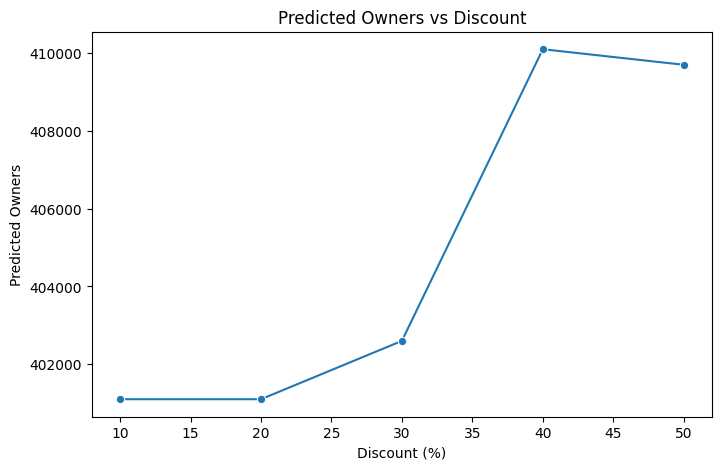

In [30]:
plt.figure(figsize=(8,5))
sns.lineplot(data=scenario_df, x='discount', y='predicted_owners', marker='o')
plt.title("Predicted Owners vs Discount")
plt.xlabel("Discount (%)")
plt.ylabel("Predicted Owners")
plt.show()


The table and graph show that as the discount increases from 10% to 40%, the predicted number of owners rises from about 401,100 to 410,100. However, at 50%, the predicted ownership slightly drops to 409,700, suggesting that while moderate discounts drive higher ownership, very large discounts may not continue this trend. The increase is gradual at first and becomes more noticeable at higher discounts, but the small dip at 50% indicates that beyond a certain point, deeper discounts might not yield additional growth in ownership.

#4. Conclusion

This analysis explored how discounts, pricing, and player activity influence game popularity and engagement on Steam. The results show that while discounts can modestly increase game ownership, their effect is limited compared to factors like player engagement and community feedback. Random Forest modeling revealed that positive and negative reviews, as well as concurrent player counts (CCU), are the strongest predictors of game popularity, while price and discount rate have minimal impact.

Overall, the findings suggest that successful games are driven more by sustained player interest and reputation than by temporary pricing strategies. Developers aiming to boost popularity should prioritize improving gameplay experience and fostering active player communities rather than relying heavily on steep discounts.